# Initial setup

In [2]:
%load_ext autoreload
%autoreload 2

import sys

if "../src" not in sys.path:
    sys.path.append("../src")

In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

from auto_bpsm.petromod_executables import PetroMod
from auto_bpsm.petromod_project import PetroModProject
from auto_bpsm.petromod_models import OneDimensionalModel
from auto_bpsm.opensim_utils.present_day_results import get_layer_data, get_layers_indecies, get_layer_data_table

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

PetroMod.get_petromod_folders()

[WindowsPath('C:/Program Files/Schlumberger/PetroMod 2017.1/WIN64/bin'),
 WindowsPath('C:/Program Files/Schlumberger/PetroMod 2020.1/WIN64/bin'),
 WindowsPath('C:/Program Files/Schlumberger/PetroMod 2022.1/WIN64/bin'),
 WindowsPath('C:/Program Files/Schlumberger/PetroMod 2023.1/WIN64/bin')]

# Loading the project

In [26]:
project_folder = Path("../data/anshuman/anshuman_v2017")
lithology_priors_filename = Path("../data/anshuman/input_data/lithology_priors.csv")
calibration_filenames = {
    "Porosity (effective)": Path("../data/anshuman/input_data/calibration_porosity.csv"),
    "Temperature": Path("../data/anshuman/input_data/calibration_temperature.csv"),
    "Pore Pressure": Path("../data/anshuman/input_data/calibration_pressure.csv"),
}
model_name = "ST168"

# Load project and model
project = PetroModProject(project_folder,petromod_folder_index=0)
lithology = project.load_lithology()
model : OneDimensionalModel = project.load_model(model_name)

# Load lithology priors
lithology_priors_table = pd.read_csv(lithology_priors_filename)

# Load calibration tables
calibration_tables = {prop: pd.read_csv(filename) for prop, filename in calibration_filenames.items()}

# Heat prior
heat_prior_mu = 47
heat_prior_sigma = 3

# Prepare variables
lithology_uncertain_properties = ["Athy's Factor k (depth)", "Anisotropy Factor Permeability", "Scaling Factor", "Specific Surface Area", "Initial Porosity"]
abbreviations = ['c', 'alpha_k', 'F', 'S', 'phi_0']
min_values = [.1, 1.1, .001, .1e7, .36  ]
max_values = [.9, 5.5, 25, 12e7,  .75]
lithology_uncertain_properties_mu = [prop+"_mu" for prop in lithology_uncertain_properties]
lithology_uncertain_properties_sigma = [prop+"_sigma" for prop in lithology_uncertain_properties]
lithology_names = lithology_priors_table['lithology'].values

In [13]:
lithology_priors_table

,layer,lithology,clay_content_fraction,Athy's Factor k (depth)_mu,Athy's Factor k (depth)_sigma,Initial Porosity_mu,Initial Porosity_sigma,Specific Surface Area_mu,Specific Surface Area_sigma,Scaling Factor_mu,Scaling Factor_sigma,Anisotropy Factor Permeability_mu,Anisotropy Factor Permeability_sigma
0,1,Pliesto_Surface,NaN,0.50,0.20,0.550,0.06,50500000.0,40000000.0,2.45,6,3.10,1.5
1,2,Pliesto_Shaly_Vsh60,0.60,0.50,0.18,0.564,0.04,70400000.0,30000000.0,1.48,4,2.22,1.2
2,3,Plio_Up_Vsh55,0.55,0.44,0.18,0.547,0.04,65400000.0,30000000.0,1.91,4,2.41,1.2
3,4,Plio_LSandy_Vsh45,0.45,0.34,0.18,0.513,0.04,50000000.0,30000000.0,3.15,4,3.29,1.2
4,5,Mio_Up_Vsh50,0.50,0.39,0.18,0.530,0.04,60500000.0,30000000.0,2.50,4,2.60,1.2
5,6,Mio_Sandy0_Vsh36,0.36,0.50,0.20,0.550,0.06,50500000.0,40000000.0,2.45,6,3.10,1.5
6,7,Mio_Shaly1_Vsh70,0.70,0.55,0.18,0.598,0.04,80300000.0,30000000.0,0.89,4,1.84,1.2
7,8,Mio_Sandy1_Vsh36,0.36,0.50,0.20,0.550,0.06,50500000.0,40000000.0,2.45,6,3.10,1.5
8,9,Mio_Shaly2_Vsh60,0.60,0.50,0.18,0.564,0.04,70400000.0,30000000.0,1.48,4,2.22,1.2
9,10,Mio_Lower,NaN,0.50,0.20,0.550,0.06,50500000.0,40000000.0,2.45,6,3.10,1.5


In [54]:
import pandas as pd

min_max_table = pd.DataFrame()
for lithology_index, lithology_name in enumerate(lithology_names):

    # Get the random variable parameters
    sigmas = lithology_priors_table[lithology_uncertain_properties_sigma].iloc[lithology_index,:].values
    mus = lithology_priors_table[lithology_uncertain_properties_mu].iloc[lithology_index,:].values

    # Sample from normals
    property_values_low = mus - 2*sigmas
    property_values_high = mus + 2*sigmas
    property_values_low = [max(l, min_value) for l, min_value in zip(property_values_low, min_values)]
    property_values_high = [min(l, max_value) for l, max_value in zip(property_values_high, max_values)]

    row_dict = {prop: [f'{round(low,2)} - {round(high,2)}'] for prop, low, high in zip(lithology_uncertain_properties, property_values_low, property_values_high)}
    row_dict['lithology'] = lithology_name
    row = pd.DataFrame.from_dict(row_dict)
    min_max_table = pd.concat([min_max_table, row])

min_max_table.to_clipboard()

# Creating the priors

In [10]:
# Update lithology
for lithology_index, lithology_name in enumerate(lithology_names):

    # Get the random variable parameters
    sigmas = lithology_priors_table[lithology_uncertain_properties_sigma].iloc[lithology_index,:].values
    mus = lithology_priors_table[lithology_uncertain_properties_mu].iloc[lithology_index,:].values

    # Sample from normals
    property_values = np.random.normal(mus, sigmas)

    # Update the lithology
    property_dict = {prop:val for prop,val in zip(lithology_uncertain_properties, property_values)}
    lithology.update_lithology_parameter(lithology_name, property_dict)

project.save_lithology()

# Update heatflow
heat_value = np.random.normal(heat_prior_mu, heat_prior_sigma)
heat_value = 45
model.heat_flow.table['Value'] = heat_value
model.heat_flow.save()

# Run the model

In [11]:
# Run the model
log = project.run_model("ST168")

# Get the results
layer_names = ["Depth", "Porosity (effective)", "Temperature", "Pore Pressure"]
results_table = get_layer_data_table(project, model_name, layer_names)
results_table['Temperature'] = results_table['Temperature'] -272.15
results_table

,Depth,Porosity (effective),Temperature,Pore Pressure
0,167.854767,0.544497,10.537378,1.824000
1,314.226715,0.521305,14.986261,3.328498
2,460.603546,0.499136,19.360315,4.835008
3,606.986389,0.477953,23.664575,6.343754
4,753.375610,0.457710,27.903802,7.854529
5,899.771545,0.438350,32.082239,9.365977
6,1067.088867,0.418513,36.787988,11.094267
7,1204.419800,0.332280,40.473840,12.562004
8,1341.761108,0.309057,44.090906,14.040010
9,1479.114258,0.287623,47.646570,15.529698


# Plot results

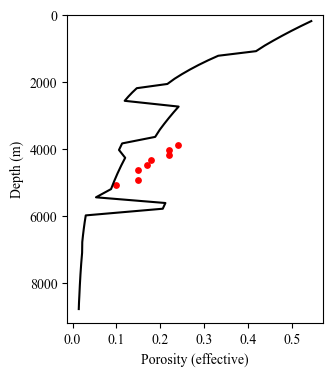

In [55]:
layer_names = ["Depth", "Porosity (effective)"]
y = results_table["Depth"].values
n_plots = len(layer_names)-1
fig, axs = plt.subplots(1,n_plots, figsize=(3.3*n_plots,4))
if not isinstance(axs, list):
    axs = [axs,]

for i, layer_name in enumerate(layer_names[1:]):
    x = results_table[layer_name].values
    calibration_data = calibration_tables[layer_name]
    ax = axs[i]
    ax.plot(x, y, color='k')
    ax.set_ylim([0, None])
    ax.invert_yaxis()
    ax.set_xlabel(layer_name)
    if i==0:
        ax.set_ylabel("Depth (m)")
    else:
        ax.set_yticklabels([])

    y_calibration = calibration_data.iloc[:,0].values
    x_calibration = calibration_data.iloc[:,1].values
    ax.scatter(x_calibration, y_calibration, color='r', s=15)

# Calculate errors

In [30]:
y = results_table["Depth"].values

mean_square_errors = []
r_squareds = []
for i, layer_name in enumerate(layer_names[1:]):
    print(layer_name)
    x = results_table[layer_name].values
    calibration_data = calibration_tables[layer_name]
    y_calibration = calibration_data.iloc[:,0].values
    x_calibration = calibration_data.iloc[:,1].values

    x_interp = np.interp(y_calibration, y,x)

    mse = mean_squared_error(x_calibration, x_interp)
    mean_square_errors.append(mse)
    r2 = r2_score(x_calibration, x_interp)
    r2 = np.max([0, r2])
    r_squareds.append(r2)

mean_square_errors

Porosity (effective)


[0.007457998876469484]

In [12]:
import optuna
def objective(trial:optuna.Trial):

    # Update Lithological parameters
    property_dicts = {}
    for lithology_index, lithology_name in enumerate(lithology_names):
        
        # Get the random variable parameters
        sigmas = lithology_priors_table[lithology_uncertain_properties_sigma].iloc[lithology_index,:].values
        mus = lithology_priors_table[lithology_uncertain_properties_mu].iloc[lithology_index,:].values
        
        # Sample from normals
        # property_values = np.random.normal(mus, sigmas)
        property_values_low = mus - 2*sigmas
        property_values_high = mus + 2*sigmas

        property_values = []
        for i, lithology_uncertain_property in enumerate(lithology_uncertain_properties):
            name =  lithology_name + "_" + lithology_uncertain_property
            value = trial.suggest_float(name, property_values_low[i], property_values_high[i])
            property_values.append(value)
        
        # Update the lithology
        property_dict = {prop:val for prop,val in zip(lithology_uncertain_properties, property_values)}
        property_dicts[lithology_name] = property_dict
        lithology.update_lithology_parameter(lithology_name, property_dict)
    
    trial.set_user_attr('property_dicts', property_dicts)
    project.save_lithology()

    # Update heatflow
    # heat_flow_low = heat_prior_mu-2*heat_prior_sigma
    # heat_flow_high = heat_prior_mu+2*heat_prior_sigma
    # heat_value =  trial.suggest_float("Heat flow", heat_flow_low, heat_flow_high)
    # model.heat_flow.table['Value'] = heat_value
    model.heat_flow.table['Value'] = 45
    model.heat_flow.save()

    # Run the model and get the results
    log = project.run_model("ST168")
    layer_names = ["Depth", "Porosity (effective)", "Temperature", "Pore Pressure"]
    layer_names = ["Depth", "Porosity (effective)"]
    results_table = get_layer_data_table(project, model_name, layer_names)
    trial.set_user_attr('results_table', results_table)
    # results_table['Temperature'] = results_table['Temperature'] -272.15

    # Calculate the errors
    y = results_table["Depth"].values
    mean_square_errors = []
    r_squareds = []
    for i, layer_name in enumerate(layer_names[1:]):
        x = results_table[layer_name].values
        calibration_data = calibration_tables[layer_name]
        y_calibration = calibration_data.iloc[:,0].values
        x_calibration = calibration_data.iloc[:,1].values
        x_interp = np.interp(y_calibration, y,x)
        mse = mean_squared_error(x_calibration, x_interp)
        mean_square_errors.append(mse)
        r2 = r2_score(x_calibration, x_interp)
        r2 = np.max([0, r2])
        r_squareds.append(r2)

    return np.mean(mean_square_errors)

sampler = optuna.samplers.TPESampler()
study = optuna.create_study(study_name='PetroMod Optimization', sampler=sampler)
study.optimize(objective, n_trials=100)
study.best_params

[I 2023-07-16 07:33:23,216] A new study created in memory with name: PetroMod Optimization
[I 2023-07-16 07:33:45,927] Trial 0 finished with value: 0.005700561912928195 and parameters: {"Pliesto_Surface_Athy's Factor k (depth)": 0.6820038386332599, 'Pliesto_Surface_Anisotropy Factor Permeability': 4.397853807560923, 'Pliesto_Surface_Scaling Factor': 0.48473913881226594, 'Pliesto_Surface_Specific Surface Area': 97889617.81427792, 'Pliesto_Surface_Initial Porosity': 0.5011533120789445, "Pliesto_Shaly_Vsh60_Athy's Factor k (depth)": 0.488019273816148, 'Pliesto_Shaly_Vsh60_Anisotropy Factor Permeability': 1.450636824136881, 'Pliesto_Shaly_Vsh60_Scaling Factor': 7.429729784715121, 'Pliesto_Shaly_Vsh60_Specific Surface Area': 115866516.78115885, 'Pliesto_Shaly_Vsh60_Initial Porosity': 0.60359258472544, "Plio_Up_Vsh55_Athy's Factor k (depth)": 0.2501562824709525, 'Plio_Up_Vsh55_Anisotropy Factor Permeability': 4.578324426057275, 'Plio_Up_Vsh55_Scaling Factor': -1.0155451200028391, 'Plio_Up_Vs

{"Pliesto_Surface_Athy's Factor k (depth)": 0.45847390794865395,
 'Pliesto_Surface_Anisotropy Factor Permeability': 4.7677062048327254,
 'Pliesto_Surface_Scaling Factor': 9.232025823691485,
 'Pliesto_Surface_Specific Surface Area': 10134310.27727286,
 'Pliesto_Surface_Initial Porosity': 0.4395165666068029,
 "Pliesto_Shaly_Vsh60_Athy's Factor k (depth)": 0.654131189709429,
 'Pliesto_Shaly_Vsh60_Anisotropy Factor Permeability': 2.0549336411590122,
 'Pliesto_Shaly_Vsh60_Scaling Factor': 7.2229275591813495,
 'Pliesto_Shaly_Vsh60_Specific Surface Area': 62428356.05010823,
 'Pliesto_Shaly_Vsh60_Initial Porosity': 0.6129334644634611,
 "Plio_Up_Vsh55_Athy's Factor k (depth)": 0.6914385946948618,
 'Plio_Up_Vsh55_Anisotropy Factor Permeability': 2.3929678853261915,
 'Plio_Up_Vsh55_Scaling Factor': 3.9588853999188984,
 'Plio_Up_Vsh55_Specific Surface Area': 113747318.5990822,
 'Plio_Up_Vsh55_Initial Porosity': 0.56752998295666,
 "Plio_LSandy_Vsh45_Athy's Factor k (depth)": 0.14122944810829624,
 '

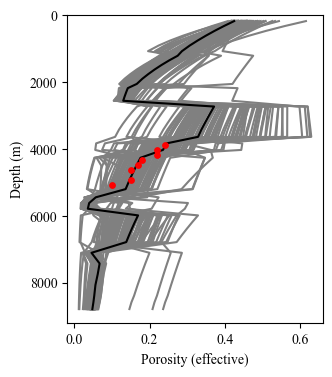

In [64]:
results_table = study.best_trial.user_attrs['results_table']

layer_names = ["Depth", "Porosity (effective)"]
y = results_table["Depth"].values
n_plots = len(layer_names)-1
fig, axs = plt.subplots(1,n_plots, figsize=(3.3*n_plots,4))
if not isinstance(axs, list):
    axs = [axs,]

for i, layer_name in enumerate(layer_names[1:]):

    ax = axs[i]
    for trial in study.trials:
        results_table_trial = trial.user_attrs['results_table']
        x = results_table_trial[layer_name].values
        ax.plot(x, y, color='gray')

    x = results_table[layer_name].values
    calibration_data = calibration_tables[layer_name]
    ax.plot(x, y, color='k')
    ax.set_ylim([0, None])
    ax.invert_yaxis()
    ax.set_xlabel(layer_name)
    if i==0:
        ax.set_ylabel("Depth (m)")
    else:
        ax.set_yticklabels([])

    y_calibration = calibration_data.iloc[:,0].values
    x_calibration = calibration_data.iloc[:,1].values
    ax.scatter(x_calibration, y_calibration, color='r', s=15, zorder=10)

In [ ]:
import joblib
# joblib.dump(study, "study.pkl")
study:optuna.Study = joblib.load("study.pkl")

In [17]:
from optuna.visualization import plot_optimization_history
plot_optimization_history(study)

Text(0, 0.5, 'Mean squared error')

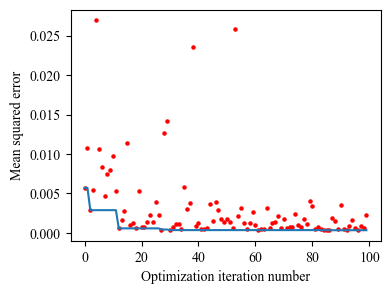

In [52]:
obj_fun_values = np.array([trial.value for trial in study.trials])
obj_fun_index = np.arange(len(obj_fun_values))
obj_fun_best = np.array([np.min(obj_fun_values[0:(i+1)]) for i in range(len(obj_fun_values))])

fig = plt.figure(figsize=(4,3))
ax = plt.subplot(1,1,1)
ax.scatter(obj_fun_index, obj_fun_values, s=5, c='r')
ax.plot(obj_fun_index, obj_fun_best)
ax.set_xlabel("Optimization iteration number")
ax.set_ylabel("Mean squared error")

In [ ]:
# Cleaned version of main optimization

import optuna
def objective(trial:optuna.Trial):

    # Update Lithological parameters
    property_dicts = {}
    for lithology_index, lithology_name in enumerate(lithology_names):
        
        # Get the random variable parameters
        sigmas = lithology_priors_table[lithology_uncertain_properties_sigma].iloc[lithology_index,:].values
        mus = lithology_priors_table[lithology_uncertain_properties_mu].iloc[lithology_index,:].values
        
        # Sample from normals
        property_values_low = mus - 2*sigmas
        property_values_high = mus + 2*sigmas
        property_values = []
        for i, lithology_uncertain_property in enumerate(lithology_uncertain_properties):
            name =  lithology_name + "_" + lithology_uncertain_property
            value = trial.suggest_float(name, property_values_low[i], property_values_high[i])
            property_values.append(value)
        
        # Update the lithology
        property_dict = {prop:val for prop,val in zip(lithology_uncertain_properties, property_values)}
        property_dicts[lithology_name] = property_dict
        lithology.update_lithology_parameter(lithology_name, property_dict)
    
    # Save updated parameters
    project.save_lithology()

    # Run the model and get the results
    log = project.run_model("1DModel")
    layer_names = ["Depth", "Porosity (effective)"]
    results_table = get_layer_data_table(project, model_name, layer_names)
    trial.set_user_attr('results_table', results_table)

    # Calculate the errors
    y = results_table["Depth"].values
    mean_square_errors = []
    for i, layer_name in enumerate(layer_names[1:]):
        x = results_table[layer_name].values
        calibration_data = calibration_tables[layer_name]
        y_calibration = calibration_data.iloc[:,0].values
        x_calibration = calibration_data.iloc[:,1].values
        x_interp = np.interp(y_calibration, y,x)
        mse = mean_squared_error(x_calibration, x_interp)
        mean_square_errors.append(mse)

    return np.mean(mean_square_errors)

sampler = optuna.samplers.TPESampler()
study = optuna.create_study(study_name='Automated calibration', sampler=sampler)
study.optimize(objective, n_trials=100)
study.best_params